# Test social group coverage in comments
To build an audience-specific question generator, we need data from specific social groups.

We will assess the coverage of social groups in the comments for the following splits:

- demographics (age, location)
- response time
- subreddit post history (within-topic or other-topics)

## Load comments
Let's get the submissions and the comment data, then restrict to all authors who asked at least one question.

In [13]:
import pandas as pd
import json
import gzip
def convert_json_to_data(data_file):
    # handling incomplete files
    raw_data = []
    try:
        for l in gzip.open(data_file, 'rt'):
            raw_data.append(json.loads(l.strip()))
    except Exception as e:
        print(f'ending data collection early because error {e}')
    data = pd.DataFrame(raw_data)
    return data
submission_data = convert_json_to_data('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz')
submission_data.rename(columns={'id':'parent_id', 'author':'parent_author', 'selftext':'submission_text', 'title':'submission_title', 'created_utc':'submission_time'}, inplace=True)
display(submission_data.head())

,parent_author,author_flair_text,submission_time,edited,parent_id,num_comments,score,submission_text,subreddit,submission_title,category,author_fullname
0,deepsouthsloth,None,1514764840,False,7nby0l,7,1,26M/married/2 kids\n\nEmployer match is 50% up...,personalfinance,Should I continue with 401k despite terrible e...,NaN,NaN
1,CapableCounteroffer,None,1514764890,False,7nby5t,5,0,"On November 24th, I called AT&amp;T to inquire...",legaladvice,[FL] Issue getting AT&amp;T to pay early termi...,NaN,NaN
2,pinkcrayon69,None,1514764948,False,7nbybf,9,3,I live in south OC but I need to move out of m...,personalfinance,I need to move out in a month. What should I p...,NaN,NaN
3,bobshellby,Needs 64bit Windows...,1514765040,False,7nbykz,6,0,Are there keycaps for the Microsoft wireless k...,pcmasterrace,Keyboard keycap help,NaN,NaN
4,j0sh135742,None,1514765064,1514765420.0,7nbyno,4,0,"So in MGL Part 1, Title 15, Chapter 94G, Secti...",legaladvice,Quick question about Medical Marijuana.,NaN,NaN


In [11]:
## get all available comment data
import os
def load_comment_data(data_dir):
    comment_files = list(filter(lambda x: x.startswith('subreddit_comments'), os.listdir(data_dir)))
    comment_files = list(map(lambda x: os.path.join(data_dir, x), comment_files))
    comment_data = list(map(lambda x: convert_json_to_data(x), comment_files))
    # combine
    combined_comment_data = pd.concat(comment_data, axis=0)
    return combined_comment_data
comment_data = load_comment_data('../../data/reddit_data/')
# fix parent ID ref
comment_data = comment_data.assign(**{
    'parent_id' : comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])
})

In [12]:
print(comment_data.shape[0])
display(comment_data.head())

4339242


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit
0,grumpypantsoldman,None,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,9t3n27,14,AmItheAsshole
1,unknown_salmon,None,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,9t1u2e,2,Advice
2,vld-s,None,t2_14p3sr,YNTA. He made you uncomfortable and you distan...,1541030467,False,e8tkkjt,9t3xz3,3,AmItheAsshole
3,Prepperpoints2Ponder,None,t2_11lpfa,Manufacturing here. Me and spouse will be payi...,1541030470,False,e8tkkns,9t2e8e,2,personalfinance
4,juliej891,None,t2_1mwezovi,I think you’re going to go out of your way to ...,1541030493,False,e8tklij,9t4afp,1,Advice


In [14]:
## combine with submissions!
non_edit_submission_data = submission_data[submission_data.loc[:, 'edited'].apply(lambda x: type(x) is bool and not x)]
submission_comment_data = pd.merge(
    comment_data, non_edit_submission_data.loc[:, ['parent_id', 'parent_author', 'submission_text', 'submission_title', 'submission_time']],
    on='parent_id'
)

In [15]:
print(submission_comment_data.shape[0])

2820097


In [19]:
## extract questions
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_questions_all_data
submission_comment_data = submission_comment_data.assign(**{
    'comment_questions' : extract_questions_all_data(submission_comment_data.loc[:, 'body'].values)
})

100%|██████████| 2820097/2820097 [17:33<00:00, 2677.35it/s] 


In [20]:
question_comment_data = submission_comment_data[submission_comment_data.loc[:, 'comment_questions'].apply(lambda x: len(x) > 0)]

In [24]:
## get distribution of subreddits
print(question_comment_data.loc[:, 'subreddit'].value_counts())

AmItheAsshole      246744
personalfinance    131389
legaladvice         90519
Advice              62733
pcmasterrace        38391
Name: subreddit, dtype: int64


In [22]:
# check for question-only comments
question_comment_data = question_comment_data.assign(**{
    'comment_is_question' : question_comment_data.apply(lambda x: x.loc['body'] == x.loc['comment_questions'][0], axis=1)
})

In [23]:
print(f'{question_comment_data.shape[0]}/{submission_comment_data.shape[0]} comments with question')
print(f'{question_comment_data[question_comment_data.loc[:, "comment_is_question"]].shape[0]}/{submission_comment_data.shape[0]} comments with question')

569776/2820097 comments with question
37547/2820097 comments with question


Overall we have about 25% questions and 1% self-contained questions, which isn't terrible. 

### Compare demographic overlap

In [26]:
## load demographic data
author_demo_data = pd.read_csv('../../data/reddit_data/1dem_vars', sep='\t', index_col=False, header=None)
author_demo_data.columns = ['author', 'age', 'gender', 'religion', 'location', 'postcount']
display(author_demo_data.head())

,author,age,gender,religion,location,postcount
0,xxxsagaxxx,UNK,UNK,UNK,usa,3191
1,subspacer,UNK,UNK,UNK,usa,744
2,silence_hr,UNK,female,UNK,europe,18007
3,Spacksack,UNK,male,UNK,europe,8934
4,uncleosbert,UNK,female,secular,usa,1005


In [30]:
demo_question_data = pd.merge(author_demo_data, question_comment_data.loc[:, ['author', 'subreddit', 'id']], on='author')
demo_question_author_data = demo_question_data.loc[:, ['author', 'gender', 'age', 'religion', 'location']].drop_duplicates('author')
print(f'{demo_question_author_data.loc[:, "author"].nunique()}/{question_comment_data.loc[:, "author"].nunique()} authors with demo data')

8514/162817 authors with demo data


OK! We have about 5% coverage of authors with at least one demographic variable, which again could be worse.

What is the distribution of demographics for each category?

In [42]:
## convert age to categories
import numpy as np
age_ranges = [20, 30, 40, 50, 60]
age_range_labels = []
for i in range(len(age_ranges)):
    if(i < len(age_ranges)-1):
        age_range_labels.append(f'{age_ranges[i]}-{age_ranges[i+1]}')
    else:
        age_range_labels.append(f'{age_ranges[i]}+')
demo_question_author_data = demo_question_author_data.assign(**{
    'age_bin' : demo_question_author_data.loc[:, 'age'].apply(lambda x: age_range_labels[np.digitize(x, age_ranges)-1] if x!='UNK' else x)
})

**** distribution for age_bin ****


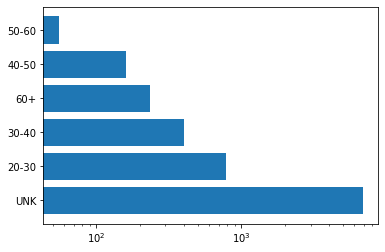

19.298% coverage for age_bin
**** distribution for gender ****


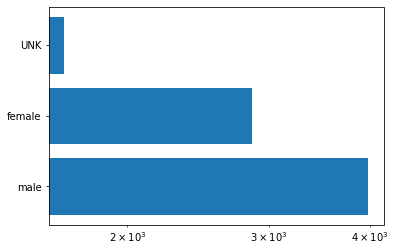

80.409% coverage for gender
**** distribution for location ****


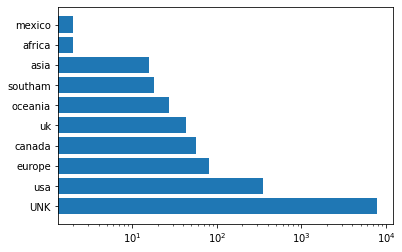

7.000% coverage for location


In [123]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
demo_vars = ['age_bin', 'gender', 'location']
max_val_count = 10
for demo_var in demo_vars:
    print(f'**** distribution for {demo_var} ****')
#     print(demo_question_author_data.loc[:, demo_var].value_counts().head(10))
    author_demo_val_counts = demo_question_author_data.loc[:, demo_var].value_counts().head(max_val_count)
    Y = np.arange(len(author_demo_val_counts))
    plt.barh(Y, width=author_demo_val_counts)
    plt.yticks(Y, author_demo_val_counts.index)
    plt.xscale('log')
    plt.show()
    coverage_pct = demo_question_author_data[demo_question_author_data.loc[:, demo_var]!="UNK"].shape[0]/demo_question_author_data.shape[0]*100
    print(f'{"{:1.3f}".format(coverage_pct)}% coverage for {demo_var}')

We have good coverage for gender, decent coverage for age and poor coverage for location.

### Check response time
Another way to divide readers is based on response time: readers who respond to the post immediately and readers who take more time to respond.

Let's look at the distribution of time responses to see if there's a reasonable split point.

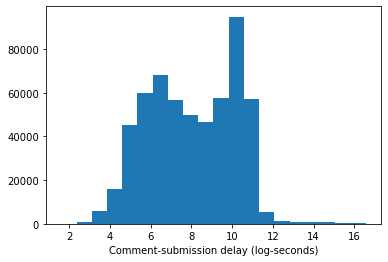

In [65]:
question_comment_data = question_comment_data.assign(**{
    'comment_submission_delay' : question_comment_data.loc[:, 'created_utc'] - question_comment_data.loc[:, 'submission_time']
})
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.kdeplot(question_comment_data.loc[:, 'comment_submission_delay'])
plt.hist(np.log(question_comment_data.loc[:, 'comment_submission_delay'].values), bins=20)
plt.xlabel('Comment-submission delay (log-seconds)')
# plt.yscale('log')
plt.show()

Most people respond to the original post within $e^{2}$ and $e^{8}$ seconds (7 sec - 1 hour), but there is a long tail of authors who only respond to the original post up to $e^{12}$ seconds afterward (45 hours).

We can split this data roughly down the middle to get the "quick responders" and the "slow responders", which we assume will be more thoughtful and well-researched due to their longer wait time.

### Check subreddit use
Among the comment authors, do we see differentiation based on prior subreddit use? I.e. people who show consistent interest in the comment subreddit vs. people with a passing interest.

Strategy: sample N commenters from each subreddit S, collect the previous M comments from each commenter (before the date of comment), compute % of comments in S, plot distribution.

We expect a bimodal distribution, i.e. authors tend to comment exclusively in the subreddit or rarely.

In [69]:
reddit_auth.index

Index(['client_id', 'client_secret'], dtype='object')

In [71]:
from praw import Reddit
reddit_auth_file = '../../data/auth_data/reddit_auth.csv'
reddit_auth = pd.read_csv(reddit_auth_file, sep=',', index_col=False).iloc[0, :]
client_id = reddit_auth.loc['client_id']
client_secret = reddit_auth.loc['client_secret']
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)
from psaw import PushshiftAPI
from datetime import datetime
pushshift_reddit_api = PushshiftAPI(reddit_api)

In [83]:
test_author = 'AutoModerator'
before_time = int(datetime(day=8, month=1, year=2019).timestamp())
after_time = int(datetime(day=1, month=1, year=2019).timestamp())
test_comments = pushshift_reddit_api.search_comments(
    before=before_time,
    after=after_time,
    author=test_author,
    limit=1000,
)
test_comments = list(test_comments)

In [85]:
print(test_comments[0].subreddit)
print(len(test_comments))

Random_Acts_Of_Pizza
971


In [84]:
## sample authors
np.random.seed(123)
author_sample_size = 100
sample_author_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    author_min_comment_dates_i = data_i.groupby('author').apply(lambda x: x.loc[:, 'created_utc'].min()).reset_index(name='min_comment_date').rename(columns={'index' : 'author'})
    sample_authors_i = np.random.choice(data_i.loc[:, 'author'].unique(), author_sample_size, replace=False)
    sample_author_data_i = author_min_comment_dates_i[author_min_comment_dates_i.loc[:, 'author'].isin(sample_authors_i)]
    sample_author_data_i = sample_author_data_i.assign(**{'subreddit' : subreddit_i})
    sample_author_data.append(sample_author_data_i)
sample_author_data = pd.concat(sample_author_data, axis=0)

In [87]:
from tqdm import tqdm
sample_author_comment_data = []
sample_author_comment_limit = 1000
for idx_i, data_i in tqdm(sample_author_data.iterrows()):
    before_time_i = data_i.loc['min_comment_date']
    author_i = data_i.loc['author']
    prior_comments_i = pushshift_reddit_api.search_comments(
        before=before_time_i,
        author=author_i,
        limit=sample_author_comment_limit,
    )
    sample_author_comment_data.extend(list(prior_comments_i))

15it [01:01,  2.59s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
479it [50:36,  7.53s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
500it [52:55,  6.35s/it]


In [100]:
print(list(sorted(sample_author_comment_data.columns)))

['_fetched', '_reddit', '_replies', '_submission', 'all_awardings', 'approved_at_utc', 'approved_by', 'archived', 'associated_award', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders', 'banned_at_utc', 'banned_by', 'body', 'body_html', 'can_gild', 'can_mod_post', 'collapsed', 'collapsed_because_crowd_control', 'collapsed_reason', 'comment_type', 'controversiality', 'created', 'created_utc', 'distinguished', 'downs', 'edited', 'gilded', 'gildings', 'id', 'is_submitter', 'likes', 'link_id', 'locked', 'mod_note', 'mod_reason_by', 'mod_reason_title', 'mod_reports', 'name', 'no_follow', 'num_reports', 'parent_id', 'permalink', 'removal_reason', 'report_reasons', 'saved', 'score', 'score_hidden', 'send_replies', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_name', 'subreddit_n

In [105]:
# sample_author_comment_data = pd.DataFrame(list(map(lambda x: x.__dict__, sample_author_comment_data)))
sample_author_comment_data = sample_author_comment_data.assign(**{
    'subreddit_name' : sample_author_comment_data.loc[:, 'subreddit'].apply(lambda x: x.display_name),
    'author_name' : sample_author_comment_data.loc[:, 'author'].apply(lambda x: x.name if x is not None else '')
})
display(sample_author_comment_data.head())

,_replies,_submission,_reddit,total_awards_received,approved_at_utc,comment_type,edited,mod_reason_by,banned_by,author_flair_type,...,subreddit_name_prefixed,controversiality,author_flair_background_color,collapsed_because_crowd_control,mod_reports,subreddit_type,ups,_fetched,subreddit_name,author_name
0,[],None,<praw.reddit.Reddit object at 0x7f5a4858dfa0>,0,None,None,False,None,None,text,...,r/food,0,None,None,[],public,2,True,food,1983alex
1,[],None,<praw.reddit.Reddit object at 0x7f5a4858dfa0>,0,None,None,False,None,None,text,...,r/food,0,None,None,[],public,6,True,food,1983alex
2,[],None,<praw.reddit.Reddit object at 0x7f5a4858dfa0>,0,None,None,False,None,None,text,...,r/OldPhotosInRealLife,0,None,None,[],public,3,True,OldPhotosInRealLife,1983alex
3,[],None,<praw.reddit.Reddit object at 0x7f5a4858dfa0>,0,None,None,False,None,None,text,...,r/Cleveland,0,None,None,[],public,1,True,Cleveland,1983alex
4,[],None,<praw.reddit.Reddit object at 0x7f5a4858dfa0>,0,None,None,False,None,None,text,...,r/OldSchoolCool,0,None,None,[],public,1,True,OldSchoolCool,1983alex


In [124]:
## save to file!!
sample_author_comment_data.to_csv('../../data/reddit_data/advice_subreddit_sample_author_prior_comment_data.gz', compression='gzip', sep='\t', index=False)

In [108]:
## get subreddit posting percents per author
sample_author_subreddit_comment_counts = sample_author_comment_data[sample_author_comment_data.loc[:, 'author_name']!=''].groupby('author_name').apply(lambda x: x.loc[:, 'subreddit_name'].value_counts() / x.shape[0]).reset_index(name='count').rename(columns={'level_1' : 'subreddit', 'author_name' : 'author'})
display(sample_author_subreddit_comment_counts.head())

,author,subreddit,count
0,-mmae,AusFinance,0.229167
1,-mmae,ethereumnoobies,0.187500
2,-mmae,LetsNotMeet,0.125000
3,-mmae,relationships,0.083333
4,-mmae,food,0.083333


In [109]:
## add original posting subreddit
sample_author_subreddit_comment_counts = pd.merge(
    sample_author_subreddit_comment_counts, sample_author_data.loc[:, ['author', 'subreddit']].rename(columns={'subreddit':'original_subreddit'}),
    on='author'   
)
display(sample_author_subreddit_comment_counts.head())

,author,subreddit,count,original_subreddit
0,-mmae,AusFinance,0.229167,legaladvice
1,-mmae,ethereumnoobies,0.187500,legaladvice
2,-mmae,LetsNotMeet,0.125000,legaladvice
3,-mmae,relationships,0.083333,legaladvice
4,-mmae,food,0.083333,legaladvice


In [110]:
def compute_original_subreddit_post_pct(data):
    original_subreddit = data.iloc[0].loc['original_subreddit']
    original_subreddit_data = data[data.loc[:, 'subreddit']==original_subreddit]
    if(original_subreddit_data.shape[0] == 0):
        post_pct = 0.
    else:
        post_pct = original_subreddit_data.iloc[0].loc['count']
    return post_pct
sample_author_original_subreddit_post_pct = sample_author_subreddit_comment_counts.groupby('author').apply(compute_original_subreddit_post_pct)

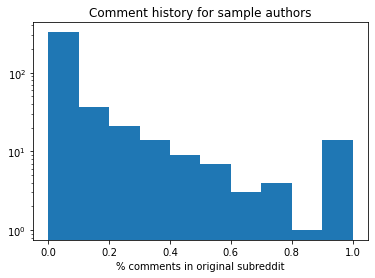

In [114]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_author_original_subreddit_post_pct)
plt.xlabel('% comments in original subreddit')
plt.yscale('log')
plt.title('Comment history for sample authors')
plt.show()

OK! Just as I suspected, we see that most authors have previously only posted a few times in the original subreddit, but a large number also posted consistently in the original subreddit.

This gives us our split between "experts" (100%) and "novices" (0-100%). We will be able to expand the "expert" group by using the subreddit cross-posting network and identifying similar subreddits to the original one.